# Stable Diffusion on Modal

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/notebooks/blob/main/notebooks/modal_sd.ipynb)

Modal is a cloud platform for deploying Python code as serverless functions. Functions can be standalone or classes with multiple methods. For clarity, I'll use "function" to refer to a unit of work running on Modal, regardless of type.

While functions can be deployed as HTTP endpoints, they can also be called directly from Python via [cloudpickle](https://github.com/cloudpipe/cloudpickle), which is what this notebook demonstrates.

I'm interested in this because:
  * no web server or client boilerplate code
  * no serialization or deserialization
  * no public endpoint that needs to be secured or rate-limited
  * scale from zero to infinity
  * build your own [ZeroGPU](https://huggingface.co/spaces/zero-gpu-explorers/README)

## Notes

To run Modal functions in your Python code, both versions need to be identical. This is a requirement of cloudpickle. If you use Modal's `debian_slim` base image, you can pass `python_version`. If you use a custom image from a registry or a local Dockerfile, then you need to ensure a matching `python` is available or pass the `add_python` argument.

Use the class syntax for _functions_ so you can define lifecycle methods (like React) to have code only run on build and start, like downloading gigabytes of weights and loading them into memory. This is known as [_amortized work_](https://modal.com/docs/guide/cold-start#reduce-time-spent-on-amortized-work).

When you run a function without a _deployment_, it is known as _ephemeral_. This creates a separate log entry for each run. After each run, the container is stopped (it doesn't seem to honor `container_idle_timeout`).

A deployment is a group of functions that comprise an application. A deployed function can be kept warm for a specified duration (defaults to 1 minute) and you can also specify a minimum number of replicas to keep warm (defaults to 0). A neat trick is to create a cron function that updates the `keep_warm` setting of a different function based on schedule (see [_adjust warm pools dynamically_](https://modal.com/docs/guide/cold-start#adjust-warm-pools-dynamically)).

Functions can be parameterized, which creates separate instances for each set of parameters. Note that the `build` lifecycle method is run at deployment, so it can't be parameterized; you must ensure the built image has all the files it will need at runtime. That said, you could still deploy a function with a few models downloaded and parameterize which one is loaded into memory.

The new [memory snapshot](https://modal.com/docs/guide/memory-snapshot) feature, which dramatically speeds up cold starts, won't work with parameterized functions. Since you can't snapshot GPU memory, you need to use a decorated class method to load the weights into CPU memory and snapshot that. Finally, when taking a snapshot, CUDA won't be available, so moving to GPU needs to be in a different method.

In [1]:
# @title Install
import modal
import os
import subprocess
import sys
from importlib.util import find_spec
from platform import python_version

modules = ["diffusers", "modal", "peft"]
if not all(find_spec(module) for module in modules):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *modules])
    os.kill(os.getpid(), 9)

In [2]:
# @title Environment
try:
    from google.colab import userdata

    MODAL_TOKEN_ID = userdata.get("MODAL_TOKEN_ID")
    MODAL_TOKEN_SECRET = userdata.get("MODAL_TOKEN_SECRET")
except ImportError:
    MODAL_TOKEN_ID = os.environ.get("MODAL_TOKEN_ID", "")
    MODAL_TOKEN_SECRET = os.environ.get("MODAL_TOKEN_SECRET", "")
finally:
    os.environ["MODAL_TOKEN_ID"] = MODAL_TOKEN_ID
    os.environ["MODAL_TOKEN_SECRET"] = MODAL_TOKEN_SECRET

In [3]:
packages = [
    "diffusers==0.30.3",
    "hf-transfer",
    "numpy==1.26.4",
    "peft",
    "torch==2.2.0",
    "torchvision==0.17.0",
]

app = modal.App.lookup("lykon--dreamshaper-8", create_if_missing=True)
image = (
    # must explicitly compile bytecode when installing with uv
    modal.Image.debian_slim(python_version=python_version())
    .env({"HF_HUB_ENABLE_HF_TRANSFER": "1"})
    .pip_install("uv")
    .run_commands(f"uv pip install --system --compile-bytecode {" ".join(packages)}")
)

with image.imports():
    import os
    import torch
    from datetime import datetime
    from diffusers import StableDiffusionPipeline
    from io import BytesIO
    from PIL import Image
    from transformers import logging
    from warnings import filterwarnings


@app.cls(
    gpu="l4",
    image=image,
    timeout=60,
    container_idle_timeout=60,
    enable_memory_snapshot=True,
    secrets=[modal.Secret.from_name("HF_TOKEN")],
)
class Cls:
    # https://huggingface.co/Lykon/dreamshaper-8
    MODEL = "Lykon/dreamshaper-8"

    @modal.build()
    def build(self):
        __import__("huggingface_hub").snapshot_download(
            repo_id=self.MODEL,
            revision="main",
            repo_type="model",
            ignore_patterns=None,
            token=os.environ["HF_TOKEN"],
            allow_patterns=[
                "feature_extractor/preprocessor_config.json",
                "safety_checker/config.json",
                "scheduler/scheduler_config.json",
                "text_encoder/config.json",
                "text_encoder/model.safetensors",
                "tokenizer/merges.txt",
                "tokenizer/special_tokens_map.json",
                "tokenizer/tokenizer_config.json",
                "tokenizer/vocab.json",
                "unet/config.json",
                "unet/diffusion_pytorch_model.safetensors",
                "vae/config.json",
                "vae/diffusion_pytorch_model.safetensors",
                "model_index.json",
            ],
        )

    # load the default fp32 weights to CPU
    @modal.enter(snap=True)
    def snapshot(self):
        filterwarnings("ignore", category=FutureWarning, module="diffusers")
        filterwarnings("ignore", category=FutureWarning, module="transformers")
        logging.set_verbosity_error()

        self.pipe = StableDiffusionPipeline.from_pretrained(
            self.MODEL,
            safety_checker=None,
            requires_safety_checker=False,
        ).to("cpu")

    # convert to half-precision for GPU
    @modal.enter(snap=False)
    def load(self):
        device = torch.device("cuda")
        self.pipe.to(
            device=device,
            dtype=torch.bfloat16 if torch.cuda.get_device_properties(device).major >= 8 else torch.float16,
        )

    @modal.method()
    def run(self, prompt, negative_prompt, num_inference_steps, guidance_scale, width, height, seed):
        if not prompt:
            raise ValueError("Prompt cannot be empty")

        if seed is None or seed < 0:
            seed = int(datetime.now().timestamp() * 1e6) % 2**64

        image = self.pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            width=width,
            height=height,
            generator=torch.Generator(device=self.pipe.device).manual_seed(seed),
        ).images[0]
        byte_stream = BytesIO()
        image.save(byte_stream, format="PNG")
        return byte_stream.getvalue()


In [4]:
_ = modal.runner.deploy_app(app)

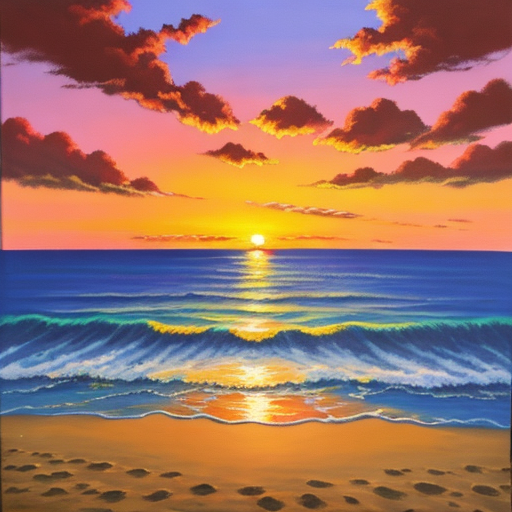

In [5]:
# Cls = modal.Cls.lookup("lykon--dreamshaper-8", "Cls")
dreamshaper = Cls()
image_bytes = dreamshaper.run.remote(
    "Acrylic painting of a beautiful sunset over the ocean",
    "ugly, watermark, clutter",
    50,
    10,
    512,
    512,
    -1,
)
image = Image.open(BytesIO(image_bytes))
display(image)